In [2]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance # clarity of the image
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from transformers import BertTokenizer, TFBertForSequenceClassification, ViTFeatureExtractor, TFViTForImageClassification
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import numpy as np
import random
from PIL import Image, ImageEnhance # clarity of the image
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from transformers import BertTokenizer, TFBertForSequenceClassification, ViTFeatureExtractor, TFViTForImageClassification
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16 #transfer learning
from sklearn.utils import shuffle # shud not overfit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16 #transfer learning
from sklearn.utils import shuffle # shud not overfit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
train_dir = '/content/drive/MyDrive/Brain_tumor/Training'
test_dir = '/content/drive/MyDrive/Brain_tumor/Testing'

import os
from sklearn.preprocessing import LabelEncoder



In [54]:
import os

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
  # Check if the item is a directory before proceeding
  if os.path.isdir(os.path.join(train_dir, label)):
    for image in os.listdir(os.path.join(train_dir, label)):
      train_paths.append(os.path.join(train_dir, label, image ))
      train_labels.append(label)
      # we go to train paths we are appending the directory image
      # and this we can do the same thing with labels

    train_paths, train_labels  = shuffle(train_paths, train_labels)
train_paths


IndentationError: unexpected indent (<ipython-input-54-1530ab323637>, line 17)

In [6]:

# below we are doing for the test directory
import os
from sklearn.utils import shuffle

test_dir = "/content/drive/MyDrive/Brain_tumor/Testing"  # Update this with the actual path

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    # Check if the item is a directory before proceeding
    if os.path.isdir(os.path.join(test_dir, label)):
        for image in os.listdir(os.path.join(test_dir, label)):
            test_paths.append(os.path.join(test_dir, label, image))
            test_labels.append(label)

# Shuffle the collected paths and labels
test_paths, test_labels = shuffle(test_paths, test_labels)

# so what we have is basically all the atest paths in atest paths [],
# and whatever test_labels we have is in the test labels, that is


In [7]:
# above we will run a loop on each directory and

import random
import numpy as np
import matplotlib.pyplot as plt

# select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)
random_indices

[3268, 1509, 4159, 699, 5216, 2973, 4793, 3025, 5499, 4144]

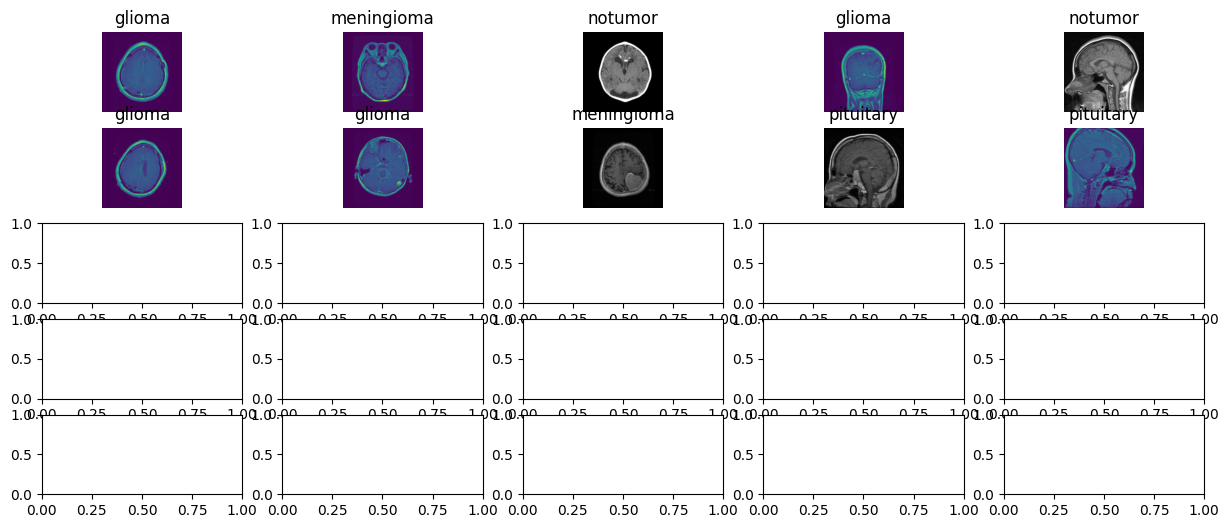

In [8]:
# create a figure to display images in 2 rows
fig, axes = plt.subplots(5,5, figsize=(15,6))
axes = axes.ravel()

#loop through the random indices and display images
for i, idx in enumerate(random_indices): # Changed 'inx' to 'idx'
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((224,224))
  axes[i].imshow(img)
  axes[i].set_title(train_labels[idx])
  axes[i].axis('off')
  axes[i].set_title(train_labels[idx]) # Changed 'axis' to 'axes' to match the defined variable
  axes[i].axis('off') # Changed 'axis' to 'axes' to match the defined variable

In [9]:
import numpy as np
import random
from PIL import Image, ImageEnhance

# Image augmentation function
def augment_image(image):
    """Apply basic augmentation: resize, brightness, and contrast adjustments."""
    image = Image.fromarray(np.uint8(image))
    image = image.resize((128, 128))

    # Apply random brightness enhancement
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))

    # Apply random contrast enhancement
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))

    # Convert back to numpy array and normalize
    image = np.array(image) / 255.0
    return image

# Load images and apply augmentation
def open_images(paths, image_size=128):
    images = []
    for path in paths:
        image = Image.open(path).convert("RGB")  # Ensure RGB format
        image = image.resize((image_size, image_size))  # Resize to match model input
        image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
        image = augment_image(image)  # Apply augmentation
        images.append(image)
    return np.array(images)

# Encode labels (convert label names to integers)
def encode_label(labels):
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    return encoded_labels

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    """Yields batches of images and encoded labels for training."""
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Fix incorrect function call
            yield batch_images, batch_labels  # Yield batch of images and labels


In [10]:
#model architecture
image_size = 128
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
for layer in base_model.layers:
  layer.trainable = False

#set only the last few layers
base_model.layers[-1].trainable = True
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [12]:
# Assuming 'train_dir' is your directory variable
len(train_dir)  # Use your train_dir variable instead of os.TRAIN_DIR

43

In [13]:
len(os.listdir(train_dir))

5

In [14]:
# build model
model = Sequential()
model.add(Input(shape=(image_size, image_size, 3)))
model.add(base_model)
model.add(Flatten())

model.add(Dropout(0.3))

model.add(Dense(128, activation = 'relu')) # Changed 'dense' to 'Dense' and 'reulu' to 'relu'
model.add(Dropout(0.3))

# Correcting the typo from 'os.listfir' to 'os.listdir' and adding activation function
model.add(Dense(len(os.listdir(train_dir)), activation='softmax')) # Assuming you want 'softmax' for classification

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
#compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['sparse_categorical_accuray'])

#parameters
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 10

#compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
#parameters
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 8

#train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    steps_per_epoch=steps,
                    epochs=epochs)



Epoch 1/8
286/286 ━━━━━━━━━━━━━━━━━━━━ 1444s 5s/step - loss: 1.4146 - sparse_categorical_accuracy: 0.2740
Epoch 2/8
286/286 ━━━━━━━━━━━━━━━━━━━━ 1414s 5s/step - loss: 1.3998 - sparse_categorical_accuracy: 0.2681
Epoch 3/8
286/286 ━━━━━━━━━━━━━━━━━━━━ 1363s 5s/step - loss: 1.4004 - sparse_categorical_accuracy: 0.2698
Epoch 4/8
286/286 ━━━━━━━━━━━━━━━━━━━━ 1345s 5s/step - loss: 1.3955 - sparse_categorical_accuracy: 0.2704
Epoch 5/8
286/286 ━━━━━━━━━━━━━━━━━━━━ 1337s 5s/step - loss: 1.3946 - sparse_categorical_accuracy: 0.2650
Epoch 6/8
249/286 ━━━━━━━━━━━━━━━━━━━━ 2:52 5s/step - loss: 1.3916 - sparse_categorical_accuracy: 0.2671

In [23]:
# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]1
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch


In [25]:
from tensorflow.keras.optimizers import Adam

# Compile the model (only once)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',  # Use sparse version
              metrics=['sparse_categorical_accuracy'])


# Parameters
batch_size = 20  # Final batch size used
steps = len(train_paths) // batch_size  # Ensure integer division
epochs = 8  # Final epoch count used

# Train the model
history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size),  # Ensure datagen is a valid generator
    steps_per_epoch=steps,
    epochs=epochs
)

Epoch 1/8
286/286 ━━━━━━━━━━━━━━━━━━━━ 1601s 6s/step - loss: 1.4962 - sparse_categorical_accuracy: 0.2632
Epoch 2/8
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 99us/step - loss: 1.3949 - sparse_categorical_accuracy: 0.2500 
Epoch 3/8


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


286/286 ━━━━━━━━━━━━━━━━━━━━ 52s 22ms/step - loss: 1.4197 - sparse_categorical_accuracy: 0.3000
Epoch 4/8
286/286 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 1.3851 - sparse_categorical_accuracy: 0.3253 
Epoch 5/8
286/286 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1.4540 - sparse_categorical_accuracy: 0.1753
Epoch 6/8
286/286 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 1.4057 - sparse_categorical_accuracy: 0.2505 
Epoch 7/8
286/286 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 1.3976 - sparse_categorical_accuracy: 0.2502
Epoch 8/8
286/286 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 1.4033 - sparse_categorical_accuracy: 0.3256 


In [46]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, label_ranking_average_precision_score, label_ranking_loss
import seaborn as sns
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

# Predict on the test set
test_predictions = model.predict(test_images)

print("classification Report")
print(classification_report(test_labels, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 245s 6s/step
classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.00      0.00      0.00       306
           2       0.31      1.00      0.47       405
           3       0.00      0.00      0.00       300

    accuracy                           0.31      1311
   macro avg       0.08      0.25      0.12      1311
weighted avg       0.10      0.31      0.15      1311



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [52]:
# Check if test_labels_encoded is defined
if 'test_labels_encoded' not in locals():
    print("Error: test_labels_encoded is not defined!"

    )


    model.save('model.h5')



In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

Confusion Matrix:
[[  0   0 300   0]
 [  0   0 306   0]
 [  0   0 405   0]
 [  0   0 300   0]]


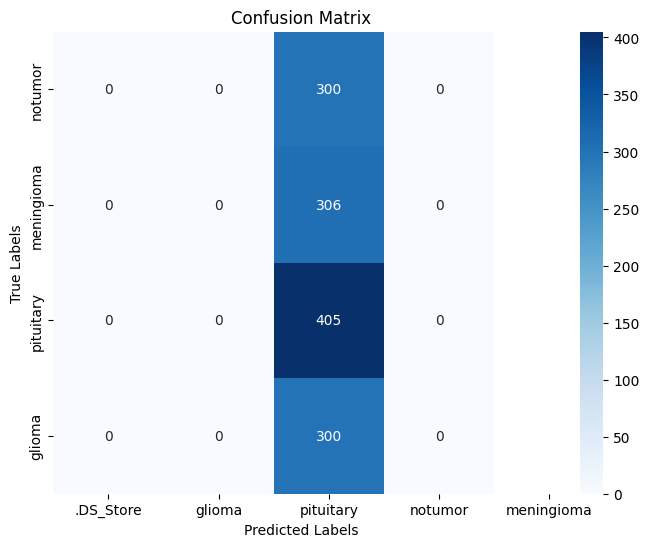

In [53]:
#t working code line
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))

# Print Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix using Seaborn Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels= os.listdir(train_dir), yticklabels= os.listdir(test_dir))


# Labels and Title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


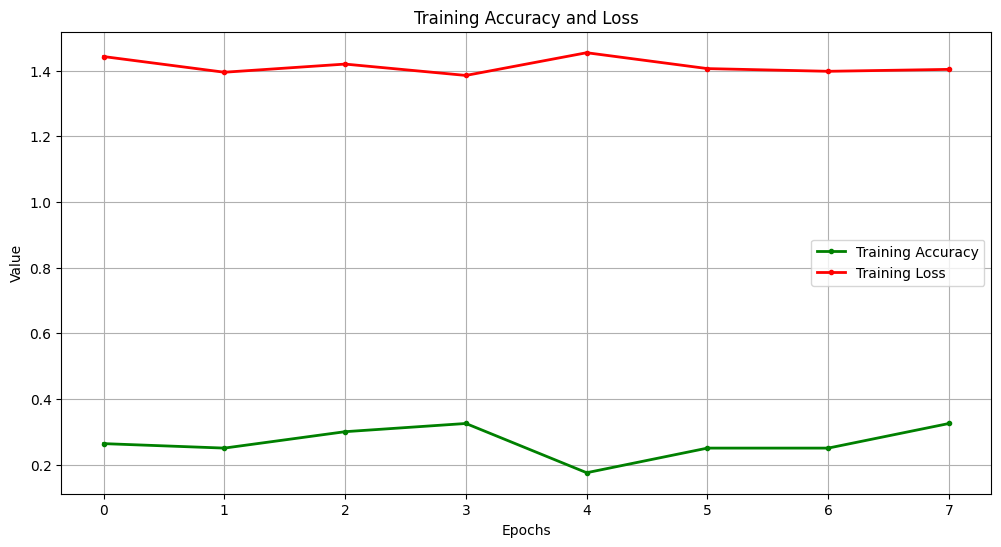

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.grid(True)

# Plot training accuracy
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2, label='Training Accuracy')

# Plot training loss
plt.plot(history.history['loss'], '.r-', linewidth=2, label='Training Loss')

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Training Accuracy and Loss")

# Legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# model load
model = load_model('model.h5')

In [38]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
def detect_and_display_tumor(image_path):
    image = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0


    # if the image belongs to notumor, then we have to say notumor, if pituatray, then we have give , that tumor, if belongs no tomor then no tumor,
    # lets give another thing that is index, fif the predicted is 0.99, that is class 2 , then we

  # prediction
   # class one = 0.9 prediction , class 2 prediction is 0.6, so we have to take the probability which is higher,
  # the class labels we have to print the class name
   # Prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    confidence_score = np.max(predictions, axis=1)[0]     # we can predict with ease, so the highest prediction, letsets see that no tumor 2 is higher, the we have to do jugard that is determine the class


  if class_labels[predited_class_index] == 'notomor':
    return "no tumor detected"
  else:
    result = f"Tumor: {class_labels[predicted_class_index]}, Confidence: {confidence_score:.2f}"
    return result

    # Check for "notumor" and return result
    if class_labels[predicted_class_index] == 'notumor':  # Changed 'predited_class_index' to 'predicted_class_index'
        return "no tumor detected"
    else:
        result = f"Tumor: {class_labels[predicted_class_index]}, Confidence: {confidence_score:.2f}"
        return result


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 24)

In [ ]:
# Example usage
image_path = '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

In [ ]:
#mri tumor detection system

from keras.preprocessing.image import load_img, img_to_array
import numpy as np

def detec:
  img = load_img(image_path, target_size=(128, 128))
  eimg_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0
  predictions = model.predict(img_array)

    except:

In [41]:

from keras.preprocessing.image import load_img, img_to_array
import numpy as np

class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
def detect_and_display_tumor(image_path):
    image = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0


    # Prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    confidence_score = np.max(predictions, axis=1)[0]


    # Check for "notumor" and return result
    # Fixing the indentation and typo in 'predited_class_index'
    if class_labels[predicted_class_index] == 'notumor':
        return "no tumor detected"
    else:
        result = f"Tumor: {class_labels[predicted_class_index]}, Confidence: {confidence_score:.2f}"
        return result

        # if no tumor , then tumor , if not , then it will print the  name of which it belongs

# display
plt.imshow(load_img(image_path))
plt.title(detect_and_display_tumor(image_path))
plt.axis('off')
plt.title(f"{result} (Confidence:) {confidence_score * 100:.2f})")
plt.show()

except Exception as e:
  print("error processing the image")

SyntaxError: invalid syntax (<ipython-input-41-ecb19765cf04>, line 35)

label amppign '{'pituitary': 0, 'notumor': 1, 'glioma': 2, 'meningioma': 3}


NameError: name 'laod_image_data' is not defined

label amppign '{'pituitary': 0, 'meningioma': 1, 'glioma': 2, 'notumor': 3}


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Brain_tumor/Training/'

In [ ]:
train_dir = '/content/drive/MyDrive/Brain_tumor/Training'
test_dir = '/content/drive/MyDrive/Brain_tumor/Testing'

Train Samples: 4585
Validation Samples: 1147
Test Samples: 1311


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
It looks like you are trying to rescale already rescaled images. If th

ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7b0571229ad0>

TypeError: AdamW.__init__() got an unexpected keyword argument 'learning_rate'

TypeError: AdamW.__init__() missing 1 required positional argument: 'params'

TypeError: AdamW.__init__() missing 1 required positional argument: 'params'

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


AttributeError: 'TFViTForImageClassification' object has no attribute 'parameters'

[]

NameError: name 'vit_model' is not defined

Train Samples: 4585
Validation Samples: 1147
Test Samples: 1311


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassificat

ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x787a47ac3710>

ValueError: mount failed

Mounted at /content/drive


Loading data...
Train Samples: 4585
Validation Samples: 1147
Test Samples: 1311


Setting up Vision Transformer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preprocessing images...


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
